# Árboles de Decisión

## Proyecto 2 - Entrega 2

In [26]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier


#imports para el modelo de arbol de decision
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:
df = pd.read_csv('data/standarized_df.csv')
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,70.0,8400,-0.820445,0.372217,-0.455469,-1.346063,0.0,3,2,...,False,False,False,True,False,False,False,False,True,False
1,60,59.0,7837,-0.088934,1.268609,0.718609,0.439214,0.0,2,4,...,False,False,False,True,False,False,False,False,True,False
2,30,67.0,8777,-0.820445,1.268609,-1.988293,-1.683818,0.0,3,4,...,False,False,False,True,False,False,False,False,True,False
3,50,60.0,7200,-0.820445,1.268609,-1.107734,-1.683818,252.0,3,4,...,False,False,False,True,False,False,False,False,True,False
4,50,50.0,5000,-0.820445,0.372217,-1.531707,-1.683818,0.0,3,4,...,False,False,False,True,False,False,False,False,True,False


### Predicción del precio de casas 

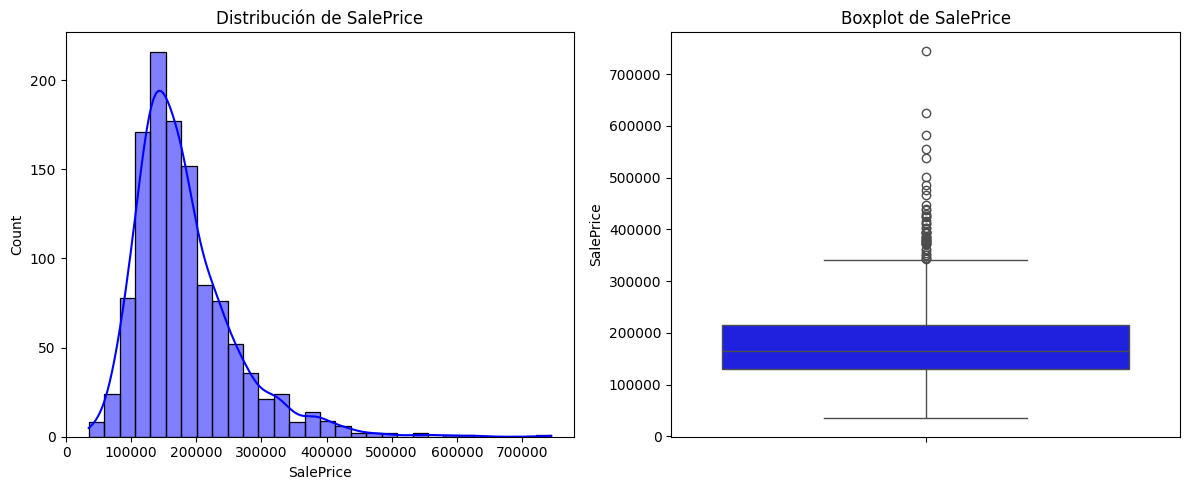

In [4]:
# 1 Exploración de la distribución de `SalePrice`
plt.figure(figsize=(12, 5))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df["SalePrice"], bins=30, kde=True, color='blue')
plt.title("Distribución de SalePrice")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=df["SalePrice"], color='blue')
plt.title("Boxplot de SalePrice")

plt.tight_layout()
plt.show()

* El histograma nos revela que la distribución de precios está sesgada a la derecha, lo que significa que hay muchas casas con precios bajos o intermedios y pocas casas con precios extremadamente altos.

* El boxplot confirma que existen outliers (casas con precios mucho más altos que el resto), pero no los eliminamos porque representan propiedades de lujo reales.

C:\Users\Cindy\AppData\Local\Temp\ipykernel_12784\1091231170.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["price_category"], palette="Set2")


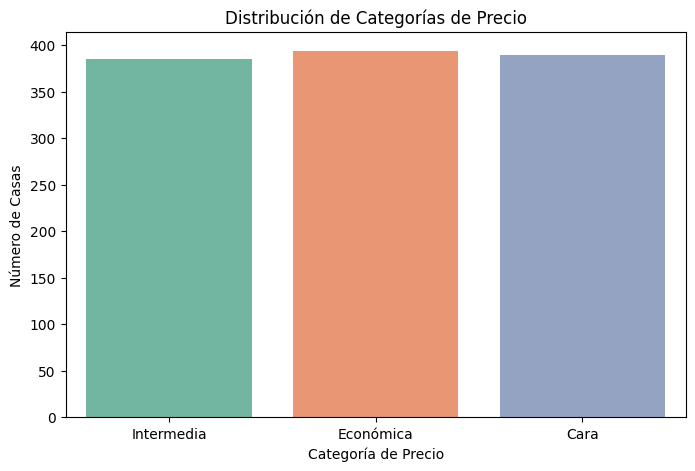

In [5]:
# 2️ Definir los umbrales de clasificación
q1 = df["SalePrice"].quantile(0.33)  # Percentil 33%
q2 = df["SalePrice"].quantile(0.66)  # Percentil 66%

# 3️ Crear la nueva variable categórica `price_category`
def categorize_price(price):
    if price <= q1:
        return "Económica"
    elif price <= q2:
        return "Intermedia"
    else:
        return "Cara"

df["price_category"] = df["SalePrice"].apply(categorize_price)

# 4️ Visualizar la segmentación
plt.figure(figsize=(8, 5))
sns.countplot(x=df["price_category"], palette="Set2")
plt.title("Distribución de Categorías de Precio")
plt.xlabel("Categoría de Precio")
plt.ylabel("Número de Casas")
plt.show()



El gráfico de barras muestra que la cantidad de casas en cada categoría es similar (~390 por grupo).

In [6]:
# Mostrar la cantidad de casas en cada categoría

category_counts = df["price_category"].value_counts().reset_index()
category_counts.columns = ["Categoría", "Cantidad de Casas"]
display(category_counts)


,Categoría,Cantidad de Casas
0,Económica,394
1,Cara,389
2,Intermedia,385


La segmentación está bien distribuida y evitará problemas de desbalance en la clasificación.

### Árbol de regresión con todas las variables disponibles

In [7]:
print(df.dtypes)

MSSubClass                 int64
LotFrontage              float64
LotArea                    int64
OverallQual              float64
OverallCond              float64
                          ...   
SaleCondition_Alloca        bool
SaleCondition_Family        bool
SaleCondition_Normal        bool
SaleCondition_Partial       bool
price_category            object
Length: 253, dtype: object


In [8]:
obj_columns = df.select_dtypes(exclude=['int64', 'float64'], include=['object']).columns # ahora para las variables tipo objeto
print(df[obj_columns])

     price_category
0        Intermedia
1        Intermedia
2         Económica
3        Intermedia
4         Económica
...             ...
1163     Intermedia
1164      Económica
1165      Económica
1166     Intermedia
1167     Intermedia

[1168 rows x 1 columns]


In [9]:
df_cleaned = pd.get_dummies(df, columns=['price_category'], drop_first=True) # drop first es para evitar multicolinearidad


In [10]:
df_cleaned.dtypes

MSSubClass                     int64
LotFrontage                  float64
LotArea                        int64
OverallQual                  float64
OverallCond                  float64
                              ...   
SaleCondition_Family            bool
SaleCondition_Normal            bool
SaleCondition_Partial           bool
price_category_Económica        bool
price_category_Intermedia       bool
Length: 254, dtype: object

In [11]:
boolean_columns = df_cleaned.select_dtypes(exclude=['int64', 'float64', 'object'], include=['bool']).columns # obtener variables booleanas
print(df_cleaned[boolean_columns].head())

   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0             False        False        False         True        False   
1             False        False        False         True        False   
2             False        False        False         True        False   
3             False        False        False         True        False   
4             False        False        False         True        False   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  ...  \
0        False         True       False       False         False  ...   
1        False         True       False       False          True  ...   
2        False         True       False       False         False  ...   
3        False         True       False       False         False  ...   
4        False         True       False        True         False  ...   

   SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0         False         Tr

In [12]:
df_cleaned[boolean_columns] = df_cleaned[boolean_columns].astype(int) # convertir a enteros
print(df_cleaned[boolean_columns].head())

   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   
2                 0            0            0            1            0   
3                 0            0            0            1            0   
4                 0            0            0            1            0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  ...  \
0            0            1           0           0             0  ...   
1            0            1           0           0             1  ...   
2            0            1           0           0             0  ...   
3            0            1           0           0             0  ...   
4            0            1           0           1             0  ...   

   SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0             0           

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


X = df_cleaned.drop("SalePrice", axis=1)
y = df_cleaned['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=5)

model = DecisionTreeRegressor(random_state=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}")
print(f"R^2: {r2}")

MSE: 1059874834.3632479
R^2: 0.8459664266780068


### Análisis del árbol con todas las variables
El árbol presenta un r^2 de 0.85, lo cual indica que quizá no existe overfitting. Sin embargo, el MSE quedó bastante alto, lo cual nos indica que el modelo se desvía de predecir los valores reales. Lo cual significa que el árbol no tenga buen desempeño a la hora de predecir los precios. 

### Desarrollo de 3 modelos adicionales

### RandomForest

In [14]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=5)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"MSE: {mse_rf}")
print(f"R^2: {r2_rf}")

MSE: 822892890.9970891
R^2: 0.8804074515669599


### SVM 

In [17]:
from sklearn.svm import SVR

svm_class = SVR(kernel='linear', C=1.0, epsilon=0.1)  # Espacio extra eliminado
svm_class.fit(X_train, y_train)

y_pred_svc = svm_class.predict(X_test)
mse_svm = mean_squared_error(y_test, y_pred_svc)
r2_svm = r2_score(y_test, y_pred_svc)
print(f"MSE: {mse_svm}")
print(f"r^2: {r2_svm}")


ValueError: Input X contains NaN.
SVR does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Creación de variable para clasificar casas en Económicas, Intermedias o Caras.

In [31]:
#  Definir X (variables predictoras) y y (variable objetivo)
X = df_cleaned.drop(columns=["SalePrice", "price_category_Económica", "price_category_Intermedia"], errors='ignore')

# Crear la variable objetivo y
y = df_cleaned[['price_category_Económica', 'price_category_Intermedia']].idxmax(axis=1)
y = y.replace({'price_category_Económica': 'Económica', 'price_category_Intermedia': 'Intermedia'})
y[~y.isin(['Económica', 'Intermedia'])] = 'Cara'  # Asignamos "Cara" cuando ninguna es 1

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

# Entrenar modelo Random Forest con **menor profundidad** para facilitar la interpretación
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=10, class_weight="balanced", random_state=5)
rf_clf.fit(X_train, y_train)

#  Predicciones
y_pred = rf_clf.predict(X_test)

#  Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo Interpretativo: {accuracy:.2f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Accuracy del modelo Interpretativo: 0.78

Reporte de clasificación:
              precision    recall  f1-score   support

   Económica       0.87      0.78      0.83       157
  Intermedia       0.63      0.77      0.69        77

    accuracy                           0.78       234
   macro avg       0.75      0.77      0.76       234
weighted avg       0.79      0.78      0.78       234



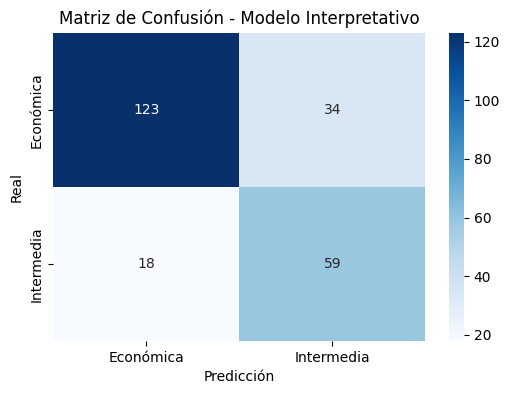

In [32]:
#  Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Modelo Interpretativo")
plt.show()



Parece que el modelo confunde un poco Economicas con Intermedias

C:\Users\Cindy\AppData\Local\Temp\ipykernel_12784\1744647035.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importancia", y="Variable", data=feature_importance, palette="viridis")
C:\Users\Cindy\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


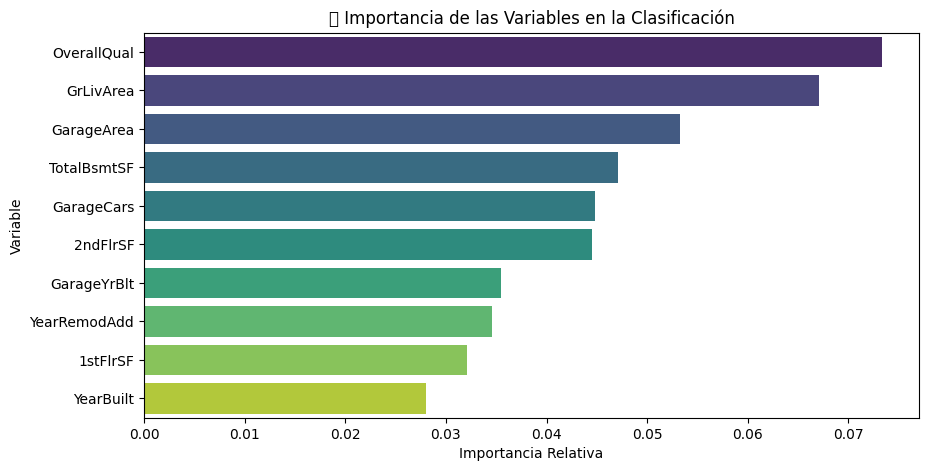

In [33]:
#  Importancia de Variables
feature_importance = pd.DataFrame({'Variable': X.columns, 'Importancia': rf_clf.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importancia", ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importancia", y="Variable", data=feature_importance, palette="viridis")
plt.xlabel("Importancia Relativa")
plt.ylabel("Variable")
plt.title("🔍 Importancia de las Variables en la Clasificación")
plt.show()


**Caracteristicas que afectan más a la clasificación**
* OverallQual - Calidad general de la casa.
* GrLivArea - Área habitable sobre el suelo.
* GarageArea - Tamaño del garaje.
* TotalBsmtSF - Tamaño total del sótano.
* GarageCars - Número de autos que entran al garaje

   **Conclusión**
    
    * Las variables de tamaño y calidad dominan la clasificación.
    * El garaje y el sótano también son factores clave.
    * Las casas Intermedias parecen compartir características con Económicas, lo que puede causar confusión en el modelo.

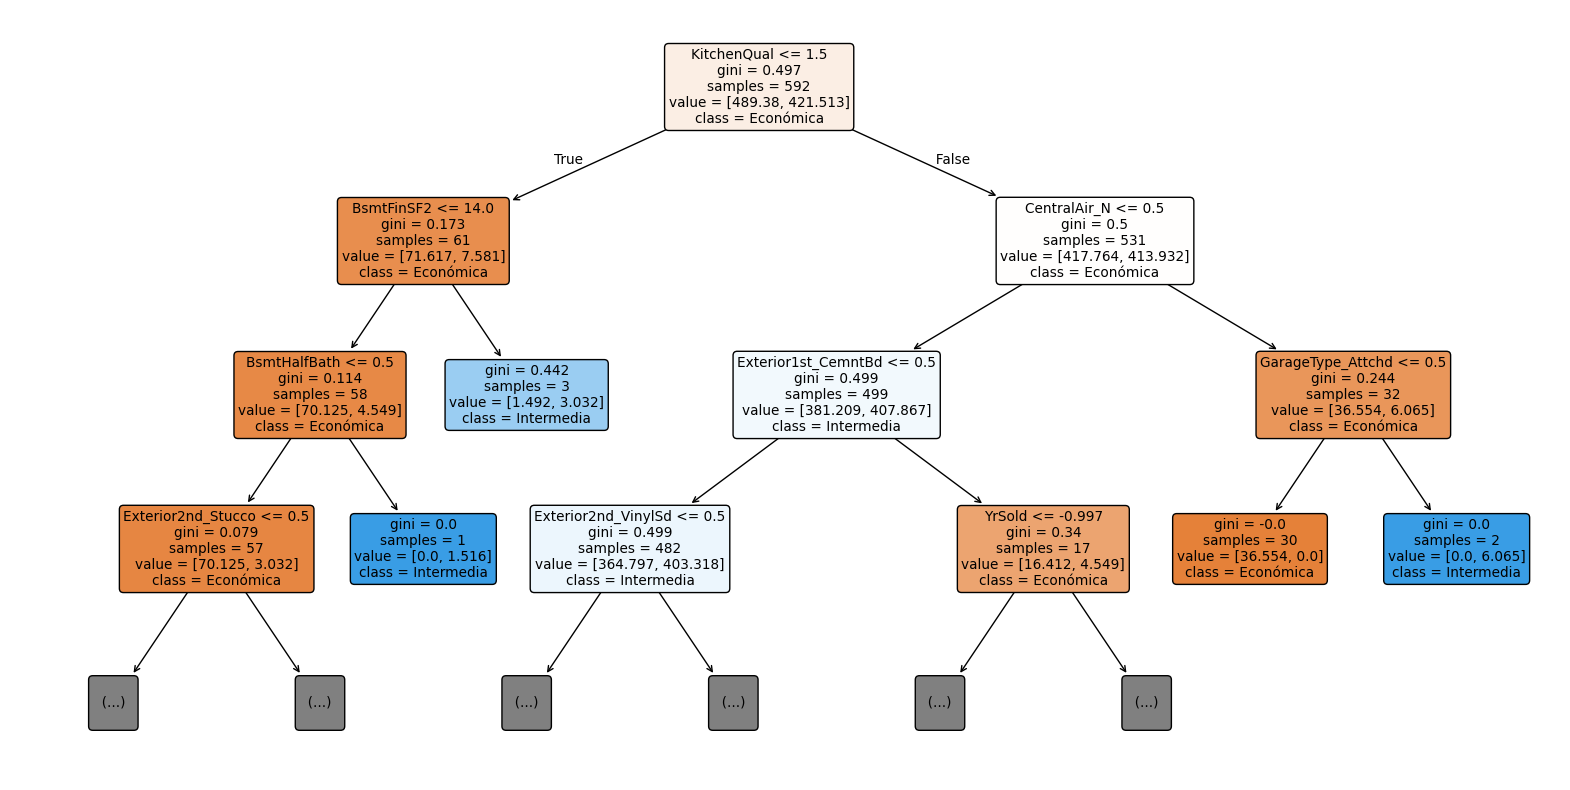

In [35]:
#  Visualizar las primeras capas de un solo árbol del Random Forest
plt.figure(figsize=(20, 10))
plot_tree(rf_clf.estimators_[0], feature_names=X.columns, class_names=rf_clf.classes_, filled=True, rounded=True, max_depth=3)
plt.show()

**Las primeras decisiones están basadas en:**

* KitchenQual (Calidad de la cocina).
* BsmtFinSF2 (Acabado del sótano).
* GarageType_Attchd (Garaje adjunto).

Evaluación del modelo

### Árbol de clasificación con variable respuesta

### Análisis de eficiencia

### Modelo con validación cruzada

### Elaboración de 3 modelos adicionales

### Utilización de Random Forest

### Resultados y Comparaciones